# American Express - Default Prediction

This notebook tries to answer the problem posted by the Kaggle Competition [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction).

## Utils

Through out this code there will be garbage created. To collect them in order to reduce RAM usage, we will create a function.

In [1]:
import gc

def collect(*args):
    for arg in args:
        del arg
    gc.collect()

## Loading the Data

In order to answer first, we will import the necessary libraries and load the datasets.

In [2]:
# imports
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

%matplotlib inline

Now let's load the dataset. We will be using a [feather dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather) created using the original dataset due to the size of the original dataset. 

In [3]:
df_train_data_temp = pd.read_feather("/kaggle/input/amexfeather/train_data.ftr")
df_test_data_temp = pd.read_feather("/kaggle/input/amexfeather/test_data.ftr")

We will reduce the dataset now using the lastest entry of each customer due to the memory limitations of the notebook.

In [4]:
df_train_data = df_train_data_temp.groupby("customer_ID").tail(1).sort_values(by=["customer_ID"])
df_train_data.reset_index(drop=True, inplace=True)
df_train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0


In [5]:
df_test_data = df_test_data_temp.groupby("customer_ID").tail(1).sort_values(by=["customer_ID"])
df_test_data.reset_index(drop=True, inplace=True)
df_test_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525


In [6]:
collect(df_train_data_temp)
collect(df_test_data_temp)

In [7]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 170.2+ MB


In [8]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924621 entries, 0 to 924620
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), datetime64[ns](1), float16(177), object(1)
memory usage: 336.0+ MB


Let's separate the target from the dataset.

In [9]:
df_train_target = df_train_data['target']
df_train_data = df_train_data.drop(['target'], axis=1)
rows, cols = df_train_data.shape

## Data Analyzing

In [10]:
# types of datatypes
train_dtypes = df_train_data.dtypes
train_dtypes.unique()

array([dtype('O'), dtype('<M8[ns]'), dtype('float16'),
       CategoricalDtype(categories=['CL', 'CO', 'CR', 'XL', 'XM', 'XZ'], ordered=False),
       CategoricalDtype(categories=['', '-1', 'O', 'R', 'U'], ordered=False),
       CategoricalDtype(categories=[0.0, 1.0], ordered=False),
       CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
       CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False),
       CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ordered=False),
       CategoricalDtype(categories=[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
       CategoricalDtype(categories=[-1.0, 0.0, 1.0], ordered=False)],
      dtype=object)

In [11]:
# datetime object col
datetime_cols = train_dtypes[train_dtypes == "<M8[ns]"].index.tolist()
datetime_cols

['S_2']

In [12]:
# category cols
# all the categories are not ordered
category_cols = train_dtypes[train_dtypes == "category"].index.tolist()
category_cols

['D_63',
 'D_64',
 'D_66',
 'D_68',
 'B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126']

In [13]:
# object cols
object_cols = train_dtypes[train_dtypes == "object"].index.tolist()
object_cols

['customer_ID']

In [14]:
# numerical cols
numerical_cols = train_dtypes[train_dtypes == "float16"].index.tolist()
numerical_cols

['P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'B_20',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 'B_32',
 'S_20',
 'R_20',
 'R_21',
 'B_33',
 'D_89',
 

## Data Visualization

### Target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

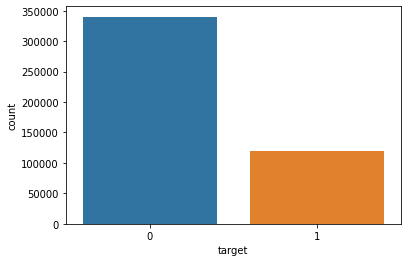

In [15]:
sns.countplot(x="target", data=df_train_target.to_frame())

## Categorical Data Visualization

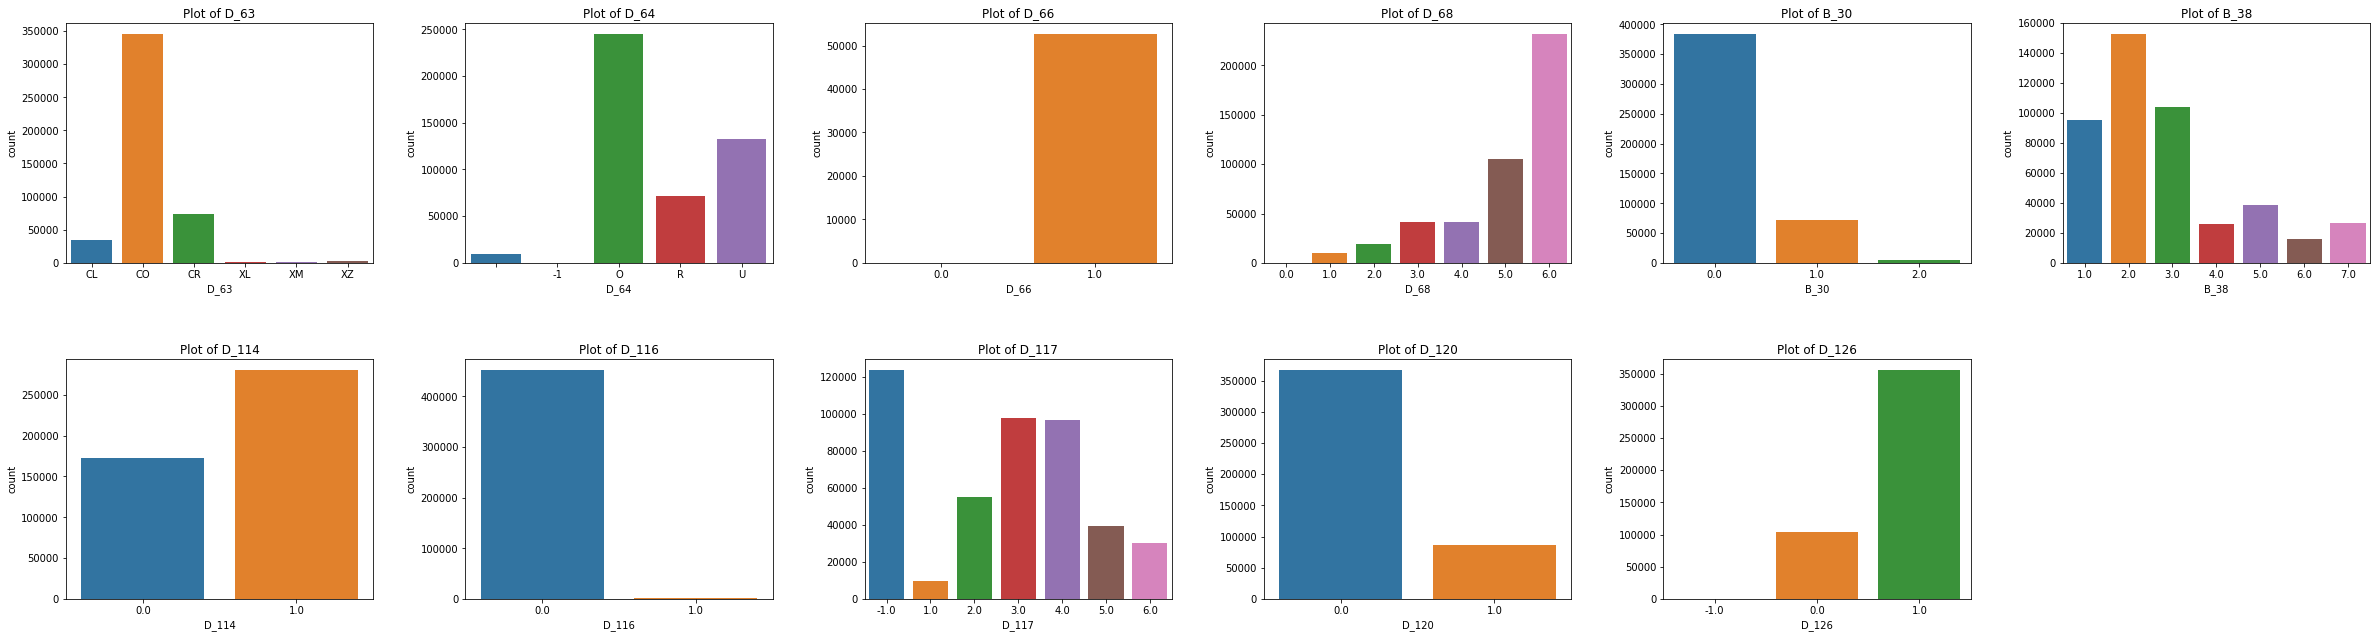

In [16]:
plt_cols = 6
plt_rows = math.ceil(len(category_cols)/plt_cols)

fig = plt.figure(figsize=(40, 10))
for i, col in enumerate(category_cols):
    ax = fig.add_subplot(plt_rows, plt_cols, i+1)
    ax.title.set_text(f"Plot of {col}")
    sns.countplot(x=col, data=df_train_data)
    
plt.subplots_adjust(
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.3,
    hspace=0.4
)
plt.show()

## Numerical Data Visualization

### Histogram Plots

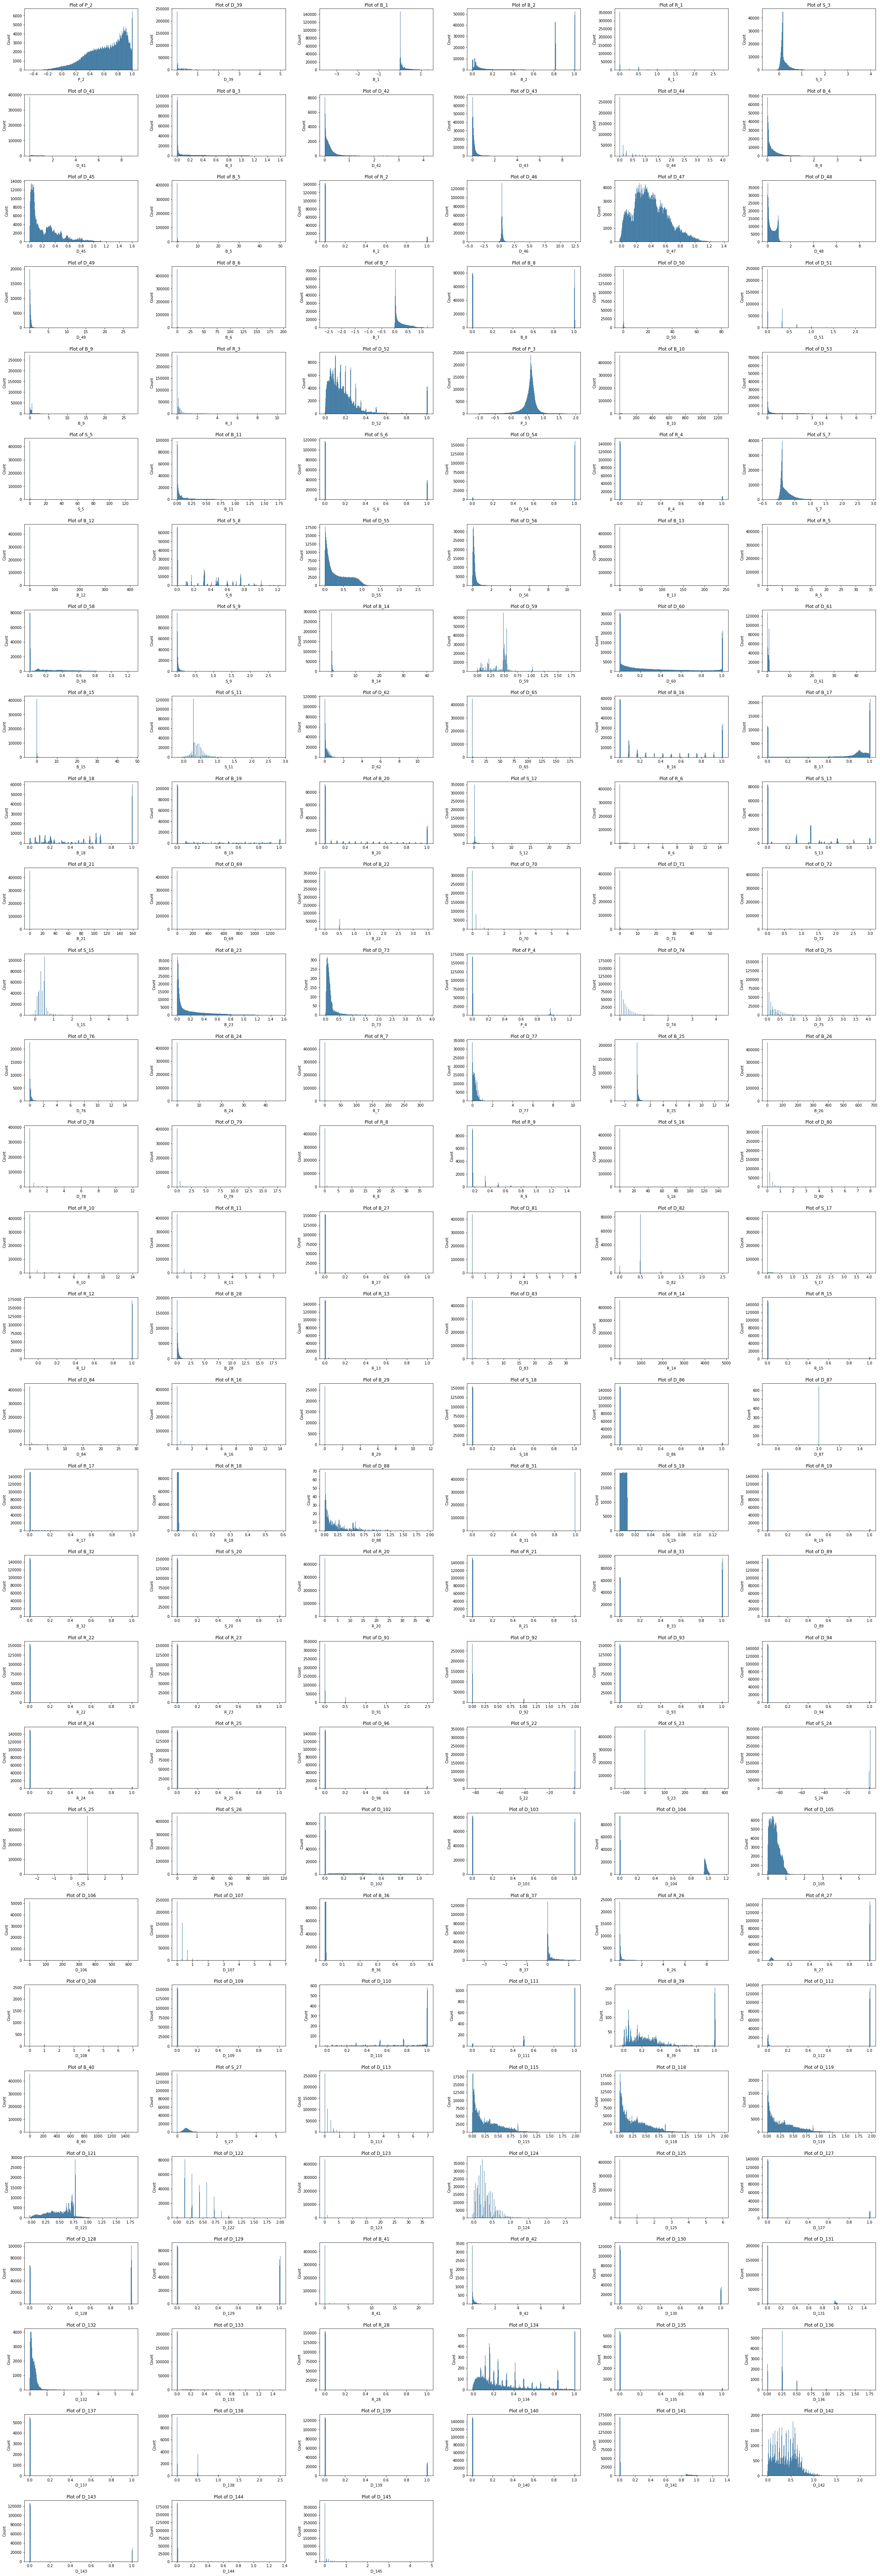

In [17]:
plt_cols = 6
plt_rows = math.ceil(len(numerical_cols)/plt_cols)

fig = plt.figure(figsize=(40, 120))
for i, col in enumerate(numerical_cols):
    ax = fig.add_subplot(plt_rows, plt_cols, i+1)
    ax.title.set_text(f"Plot of {col}")
    sns.histplot(x=col, data=df_train_data, bins=300)
    
plt.subplots_adjust(
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.3,
    hspace=0.4
)
plt.show()

### Box Plots

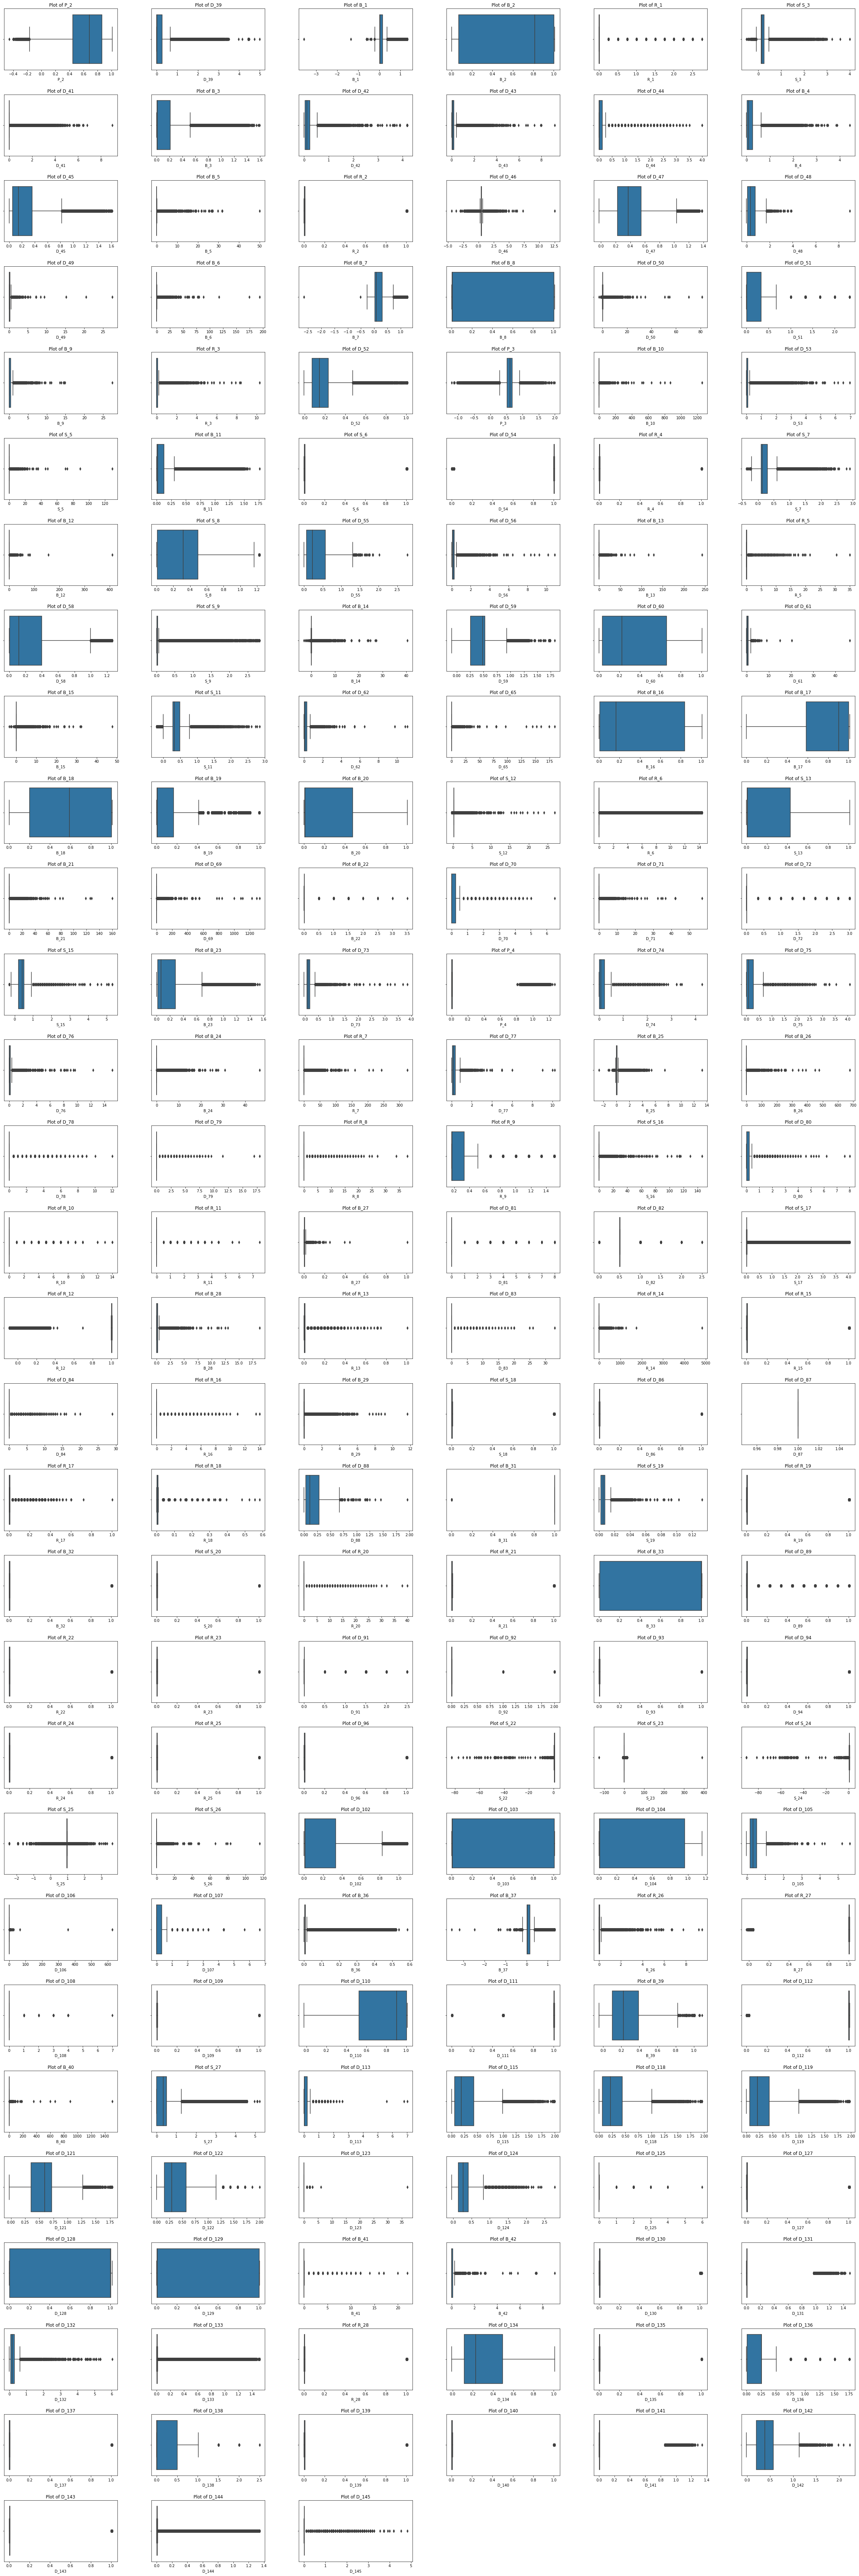

In [18]:
plt_cols = 6
plt_rows = math.ceil(len(numerical_cols)/plt_cols)

fig = plt.figure(figsize=(40, 120))
for i, col in enumerate(numerical_cols):
    ax = fig.add_subplot(plt_rows, plt_cols, i+1)
    ax.title.set_text(f"Plot of {col}")
    sns.boxplot(x=col, data=df_train_data)
    
plt.subplots_adjust(
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.3,
    hspace=0.4
)
plt.show()

## Preprocessing

### Handling Missing Values

Before handling the missing data, let's change the dtype of category features to `object` and dtype of the numerical features to `float64`.

In [19]:
df_train_data[category_cols] = df_train_data[category_cols].astype("object")
df_train_data[numerical_cols] = df_train_data[numerical_cols].astype("float64")

In [20]:
df_test_data[category_cols] = df_test_data[category_cols].astype("object")
df_test_data[numerical_cols] = df_test_data[numerical_cols].astype("float64")

In [21]:
df_train_data[category_cols].head()

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
0,CR,O,NaN,6.0,0.0,2.0,1.0,0.0,4.0,0.0,1.0
1,CO,O,NaN,6.0,0.0,2.0,1.0,0.0,-1.0,0.0,1.0
2,CO,R,NaN,6.0,0.0,1.0,1.0,0.0,-1.0,0.0,1.0
3,CO,O,NaN,3.0,0.0,2.0,1.0,0.0,6.0,0.0,1.0
4,CO,O,1.0,6.0,0.0,1.0,1.0,0.0,4.0,0.0,1.0


In this step we will drop the customer_ID and datetime columns which are not necessary for our model.

In [22]:
# drop customer_ID
df_train_data.drop(["customer_ID"], axis=1, inplace=True)

In [23]:
# drop datetime columns
df_train_data.drop(datetime_cols, axis=1, inplace=True)

Now we will drop the features with missing values more than the specified threshold.

In [24]:
# drop columns with missing data more than the THRESHOLD
THRESHOLD = 0.6

In [25]:
# drop columns
df_missing = df_train_data.isnull().sum()/rows
dropping_cols = df_missing.index[df_missing > THRESHOLD].tolist()
df_train_data.drop(dropping_cols, axis=1, inplace=True)

In [26]:
# convert test data
df_test_data_customers = df_test_data["customer_ID"]
df_test_data = df_test_data[df_train_data.columns]

### Imputing Values

For the remaining columns with missing values we will impute them using the following criterias.
- Categorical Variables: Median Values
- Numerical Variables: Mean Values

In [27]:
# columns with missing values
missing = dict()

# train data
missing_value_cols = df_train_data.columns[df_train_data.isnull().any()].tolist()
missing_value_categorical = list(set(missing_value_cols) & set(category_cols))
missing_value_numerical = list(set(missing_value_cols) & set(numerical_cols))
missing["train"] = { "categorical": missing_value_categorical, "numerical": missing_value_numerical }

# test data
missing_value_cols = df_test_data.columns[df_test_data.isnull().any()].tolist()
missing_value_categorical = list(set(missing_value_cols) & set(category_cols))
missing_value_numerical = list(set(missing_value_cols) & set(numerical_cols))
missing["test"] = { "categorical": missing_value_categorical, "numerical": missing_value_numerical }

In [28]:
# handle missing data
for col in missing["train"]["categorical"]:
    df_train_data[col].fillna(df_train_data[col].median(), inplace=True)
for col in missing["train"]["numerical"]:
    df_train_data[col].fillna(df_train_data[col].mean(), inplace=True)

for col in missing["test"]["categorical"]:
    df_test_data[col].fillna(df_test_data[col].median(), inplace=True)
for col in missing["test"]["numerical"]:
    df_test_data[col].fillna(df_test_data[col].mean(), inplace=True)

### Categorical Encoding

In this step we will encode the categorical features of the dataset using `LabelEncoder` of `sklearn`.

In [29]:
# new categorical columns after dropping columns
category_cols = df_train_data.columns[df_train_data.dtypes == "O"].tolist()

In [30]:
encoder = LabelEncoder()
for col in category_cols:
    df_train_data[col] = encoder.fit_transform(df_train_data[col])
    df_test_data[col] = encoder.transform(df_test_data[col])

### Standardization

In [31]:
# standardization
scaler = StandardScaler()

# train data
scaled_array = scaler.fit_transform(df_train_data)
df_train_data = pd.DataFrame(data=scaled_array, columns=df_train_data.columns)

# test data
scaled_array = scaler.fit_transform(df_test_data)
df_test_data = pd.DataFrame(data=scaled_array, columns=df_test_data.columns)

In [32]:
df_train_data.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
0,1.122399,-0.478353,-0.560580,1.009876,-0.363526,-0.523995,-0.321923,-0.578915,-2.906953e-16,-0.561460,...,-0.522546,-0.356562,-0.247454,-0.113745,-0.457995,-0.161544,-0.462612,-0.461433,-0.269437,-0.281277
1,0.919162,-0.058159,-0.451120,1.000398,-0.360624,-0.353977,-0.308944,-0.587171,-5.400570e-01,-0.538548,...,-0.527412,-0.368687,-0.265027,-0.152941,-0.469070,-0.140310,-0.454624,-0.468085,-0.268336,-0.281354
2,0.920993,-0.476893,-0.582634,0.535967,-0.362280,0.000000,-0.314715,-0.578840,-2.906953e-16,-0.572367,...,-0.526303,-0.363737,-0.227389,0.078406,-0.457483,-0.145924,-0.474415,-0.470938,-0.281172,-0.307157
3,-0.051250,-0.498333,-0.546823,1.005137,-0.357338,0.327459,-0.312294,-0.568071,-6.161272e-01,-0.542646,...,-0.532666,-0.360177,-0.271629,-0.020174,-0.469799,-0.148793,-0.471740,-0.455173,-0.255218,-0.309506
4,0.888035,-0.487166,-0.567953,0.544260,-0.380954,0.000000,-0.326440,-0.585376,-6.236384e-01,-0.564869,...,1.934882,-0.346306,-0.253816,-0.075506,-0.469090,-0.162018,-0.460667,-0.455254,-0.247611,-0.320085


In [33]:
df_train_data.shape

(458913, 163)

In [34]:
df_test_data.shape

(924621, 163)

### Applying Principle Component Analysis

Before applying Priciple Compenent Analysis let's split the train and test data using the provided train dataset.

In this step we will apply Principle Component Analysis to preserve 95% variance in our data.

In [35]:
pca = PCA(n_components=0.95)
pca.fit(df_train_data)

PCA(n_components=0.95)

In [36]:
df_train_data = pca.transform(df_train_data)
df_test_data = pca.transform(df_test_data)

In [37]:
df_train_data.shape

(458913, 110)

## Model

### Amex Metric for the evaluation

In [38]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

#### For testing

For testing our models let's split our training data into training and test splits with a test_size of 0.3.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_train_data, df_train_target, test_size=0.3, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [40]:
# all the models
models = dict()

Hyper Parameter Tuning

In [41]:
# XGBoost
regr = XGBRegressor()
regr.fit(X_train, y_train)
models["xgboost"] = regr.predict(X_test)
models["xgboost"]

array([ 0.6348215 ,  0.12443178,  0.865232  , ..., -0.00498477,
        0.11243584,  0.3093993 ], dtype=float32)

In [42]:
# def objective_lgbm(trial):    
#     params = {
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "max_depth": trial.suggest_int("max_depth", -1, 8),
#         "n_estimators": trial.suggest_int("n_estimators", 50, 200, 10),
#         "n_jobs": 4
#     }
    
#     regr = LGBMRegressor(**params)
#     regr.fit(X_train, y_train)
#     pred = regr.predict(X_val)
    
#     y_test_df = pd.DataFrame({'customer_ID': y_val.index, 'target': y_val.values})
#     y_pred_df = pd.DataFrame({'customer_ID': y_val.index, 'prediction': pred})
#     score = amex_metric(y_test_df, y_pred_df)
    
#     return score

In [43]:
# study_lgbm = optuna.create_study(direction="maximize")
# study_lgbm.optimize(objective_lgbm, n_trials = 100, n_jobs = 4, show_progress_bar = True)

In [44]:
# params_lgbm = study_lgbm.best_params
params_lgbm = {
    "num_leaves": 145,
    "max_depth": 7,
    "n_estimators": 190
}

In [45]:
# collect(study_lgbm)

In [46]:
# LightGBM
regr = LGBMRegressor()
regr.fit(X_train, y_train)
models["lgbm"] = regr.predict(X_test)
models["lgbm"]

array([0.69546047, 0.1393023 , 0.88047114, ..., 0.00477228, 0.1108137 ,
       0.26954782])

In [47]:
# LightGBM Tuned
regr = LGBMRegressor(**params_lgbm)
regr.fit(X_train, y_train)
models["lgbm_tuned"] = regr.predict(X_test)
models["lgbm_tuned"]

array([ 0.67988953,  0.1475039 ,  0.86650949, ..., -0.00440668,
        0.13237489,  0.31013705])

In [48]:
# def objective_catboost(trial):    
#     params = {
#         "objective": trial.suggest_categorical("objective", ["MAE", "RMSE"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": "Plain",
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]
#         ),
#         "verbose": False
#     }
    
#     regr = CatBoostRegressor(**params)
#     regr.fit(X_train, y_train)
#     pred = regr.predict(X_val)
    
#     y_test_df = pd.DataFrame({'customer_ID': y_val.index, 'target': y_val.values})
#     y_pred_df = pd.DataFrame({'customer_ID': y_val.index, 'prediction': pred})
#     score = amex_metric(y_test_df, y_pred_df)
    
#     return score

In [49]:
# study_catboost = optuna.create_study(direction="maximize")
# study_catboost.optimize(objective_catboost, n_trials = 100, n_jobs = 4, show_progress_bar = True)

In [50]:
# params_catboost = study_catboost.best_params
params_catboost = {
    "depth": 7,
    "verbose": False
}

In [51]:
# collect(study_catboost)

In [52]:
# CatBoost
regr = CatBoostRegressor(verbose=False)
regr.fit(X_train, y_train)
models["catboost"] = regr.predict(X_test)
models["catboost"]

array([ 0.65590029,  0.24633391,  0.83018335, ..., -0.00240303,
        0.11475278,  0.25895192])

In [53]:
# CatBoost Tuneed
regr = CatBoostRegressor(**params_catboost)
regr.fit(X_train, y_train)
models["catboost_tuned"] = regr.predict(X_test)
models["catboost_tuned"]

array([ 0.65715135,  0.14955122,  0.83777163, ..., -0.00727622,
        0.16204643,  0.22728253])

In [54]:
# X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(df_train_data, df_train_target, train_size=0.05, random_state=40)

In [55]:
# X_train_reduced.shape

In [56]:
# # SVM
# regr = SVR(
#     cache_size=1000,
#     verbose=True
# )
# regr.fit(X_train_reduced, y_train_reduced)
# df_test_target = regr.predict(df_test_data)
# df_test_target

In [57]:
# # KNN
# regr = KNeighborsRegressor(n_neighbors=3)
# regr.fit(X_train_reduced, y_train_reduced)
# df_test_target = regr.predict(df_test_data)
# df_test_target

#### For submissions

In [58]:
# regr = xgb.XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective ='reg:squarederror')
# regr.fit(df_train_data, df_train_target)
# df_test_target = regr.predict(df_test_data)
# df_test_target

In [59]:
# # LightGBM
# regr = LGBMRegressor()
# regr.fit(df_train_data, df_train_target)
# df_test_target = regr.predict(df_test_data)
# df_test_target

In [60]:
# regr = KNeighborsRegressor()
# regr.fit(df_train_data, df_train_target)
# pred = regr.predict(df_test_data)
# pred

In [61]:
# # CatBoost
# regr = CatBoostRegressor(verbose=False)
# regr.fit(df_train_data, df_train_target)
# df_test_target = regr.predict(df_test_data)
# df_test_target

### Evaluation

In [62]:
# dictionary for different model scores
scores = dict()
for key in models.keys():
    if key == "svm" or key == "knn":
        y_test_df = pd.DataFrame({'customer_ID': y_test_reduced.index, 'target': y_test_reduced.values})
        y_pred_df = pd.DataFrame({'customer_ID': y_test_reduced.index, 'prediction': models[key]})
        scores[key] = amex_metric(y_test_df, y_pred_df)
    else:
        y_test_df = pd.DataFrame({'customer_ID': y_test.index, 'target': y_test.values})
        y_pred_df = pd.DataFrame({'customer_ID': y_test.index, 'prediction': models[key]})
        scores[key] = amex_metric(y_test_df, y_pred_df)

In [63]:
scores_df = pd.DataFrame({
    col.upper(): [scores[col]] for col in scores.keys()
}, index=["AMEX Score"]).T
scores_df

,AMEX Score
XGBOOST,0.751251
LGBM,0.758018
LGBM_TUNED,0.759710
CATBOOST,0.765156
CATBOOST_TUNED,0.764355


## Data Saving

In [64]:
# output_df = pd.DataFrame({
#     "customer_ID": df_test_data_customers.values,
#     "prediction": df_test_target
# })
# output_df.to_csv("/kaggle/working/submission.csv", index=False)